# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [21]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [22]:
util.load_hopskey()

In [23]:
today = datetime.datetime.now() - datetime.timedelta(0)
yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 11, 17, 8, 28, 355451)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [24]:
# os.environ["HOPSWORKS_API_KEY"] = ""
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160345
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [25]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=3,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [26]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [27]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.072271E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [28]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=3,
)
batch_data = weather_fg.filter(weather_fg.date >= yesterday ).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-15 00:00:00+00:00,5.30,0.0,15.827721,72.801376,Eimsbüttel
1,2024-11-16 00:00:00+00:00,5.65,0.1,6.618519,315.000092,Eimsbüttel
2,2024-11-11 00:00:00+00:00,8.35,1.0,17.057314,224.144989,Eimsbüttel
3,2024-11-17 00:00:00+00:00,3.15,0.3,23.269482,214.919479,Eimsbüttel
4,2024-11-13 00:00:00+00:00,7.65,0.0,17.298738,77.988548,Eimsbüttel
5,2024-11-12 00:00:00+00:00,7.85,0.0,10.296251,323.530670,Eimsbüttel
6,2024-11-14 00:00:00+00:00,4.85,0.0,14.986553,65.897766,Eimsbüttel


In [29]:
# get the training feature group, becasee we need the last rolling mean
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=3,
)
train_df = air_quality_fg.read().sort_values("date")
popped_value = train_df.iloc[-3]["pm25"]     # get the first value that contributest to the last rolling mean (-3 postition)
rolling_mean = train_df.iloc[-1]["pm25_lagging"]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [30]:
batch_data.sort_values("date", inplace=True)

In [31]:
data = batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
data

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
2,8.35,1.0,17.057314,224.144989
5,7.85,0.0,10.296251,323.530670
4,7.65,0.0,17.298738,77.988548
6,4.85,0.0,14.986553,65.897766
0,5.30,0.0,15.827721,72.801376
1,5.65,0.1,6.618519,315.000092
3,3.15,0.3,23.269482,214.919479


Iteratively calculation the rolling mean of windowsize 3.

$\bar{x}_n = \bar{x}_{n-1} + \frac{x_n - x_0}{N}$  

[link](https://nestedsoftware.com/2019/09/26/incremental-average-and-standard-deviation-with-sliding-window-470k.176143.html)

In [32]:
# predict iterative and use the lst predicitons to calc the rolling mean
for i, row in data.iterrows():
    row = pd.DataFrame([row])
    row.insert(0,"pm25_lagging",rolling_mean)   # add the lagging pm25 value to the row
    prediction = retrieved_xgboost_model.predict(row)  
    batch_data.loc[i,'predicted_pm25'] = prediction
    rolling_mean = rolling_mean + (prediction - popped_value) / 3 

print(batch_data)

                       date  temperature_2m_mean  precipitation_sum  \
2 2024-11-11 00:00:00+00:00                 8.35                1.0   
5 2024-11-12 00:00:00+00:00                 7.85                0.0   
4 2024-11-13 00:00:00+00:00                 7.65                0.0   
6 2024-11-14 00:00:00+00:00                 4.85                0.0   
0 2024-11-15 00:00:00+00:00                 5.30                0.0   
1 2024-11-16 00:00:00+00:00                 5.65                0.1   
3 2024-11-17 00:00:00+00:00                 3.15                0.3   

   wind_speed_10m_max  wind_direction_10m_dominant        city  predicted_pm25  
2           17.057314                   224.144989  Eimsbüttel       12.277857  
5           10.296251                   323.530670  Eimsbüttel       11.409551  
4           17.298738                    77.988548  Eimsbüttel       12.718436  
6           14.986553                    65.897766  Eimsbüttel       15.413874  
0           15.827721     

In [33]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 2 to 3
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         7 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          7 non-null      float32            
 2   precipitation_sum            7 non-null      float32            
 3   wind_speed_10m_max           7 non-null      float32            
 4   wind_direction_10m_dominant  7 non-null      float32            
 5   city                         7 non-null      object             
 6   predicted_pm25               7 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 608.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [34]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
2,2024-11-11 00:00:00+00:00,8.35,1.0,17.057314,224.144989,Eimsbüttel,12.277857,Rentzelstraße,Germany,1
5,2024-11-12 00:00:00+00:00,7.85,0.0,10.296251,323.530670,Eimsbüttel,11.409551,Rentzelstraße,Germany,2
4,2024-11-13 00:00:00+00:00,7.65,0.0,17.298738,77.988548,Eimsbüttel,12.718436,Rentzelstraße,Germany,3
6,2024-11-14 00:00:00+00:00,4.85,0.0,14.986553,65.897766,Eimsbüttel,15.413874,Rentzelstraße,Germany,4
0,2024-11-15 00:00:00+00:00,5.30,0.0,15.827721,72.801376,Eimsbüttel,16.845076,Rentzelstraße,Germany,5
1,2024-11-16 00:00:00+00:00,5.65,0.1,6.618519,315.000092,Eimsbüttel,16.063313,Rentzelstraße,Germany,6
3,2024-11-17 00:00:00+00:00,3.15,0.3,23.269482,214.919479,Eimsbüttel,21.791859,Rentzelstraße,Germany,7
5,2024-11-14 00:00:00+00:00,10.35,0.0,22.545315,321.483032,Eimsbüttel,10.087353,Rentzelstraße,Germany,4
0,2024-11-15 00:00:00+00:00,10.45,0.0,14.154915,277.305664,Eimsbüttel,11.604922,Rentzelstraße,Germany,5
1,2024-11-16 00:00:00+00:00,8.70,0.0,9.360001,202.619904,Eimsbüttel,9.647716,Rentzelstraße,Germany,6


In [35]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 2 to 3
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         7 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          7 non-null      float32            
 2   precipitation_sum            7 non-null      float32            
 3   wind_speed_10m_max           7 non-null      float32            
 4   wind_direction_10m_dominant  7 non-null      float32            
 5   city                         7 non-null      object             
 6   predicted_pm25               7 non-null      float32            
 7   street                       7 non-null      object             
 8   country                      7 non-null      object             
 9   days_before_forecast_day     7 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-11 17:08:44,879 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



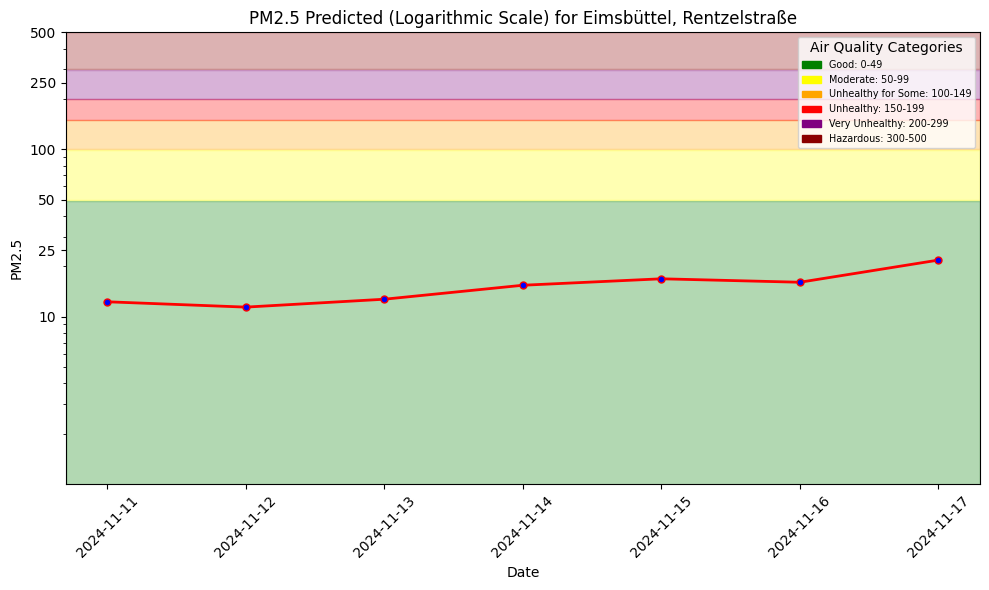

In [36]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [37]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=3,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [38]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/7 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160345/jobs/named/aq_predictions_3_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f62fdd09ee0>, None)

In [39]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-15 00:00:00+00:00,5.30,0.0,15.827721,72.801376,Eimsbüttel,10.492915,Rentzelstraße,Germany,1
1,2024-11-11 00:00:00+00:00,8.35,1.0,17.057314,224.144989,Eimsbüttel,12.277857,Rentzelstraße,Germany,1


In [40]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=3,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.18s) 


,date,pm25,pm25_lagging,country,city,street,url
0,2020-11-10 00:00:00+00:00,46.520000,42.506668,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1,2020-08-21 00:00:00+00:00,13.740000,11.223333,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
2,2023-03-05 00:00:00+00:00,3.600000,3.473333,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
3,2023-07-31 00:00:00+00:00,5.600000,6.013333,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
4,2020-12-19 00:00:00+00:00,17.799999,19.150000,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
...,...,...,...,...,...,...,...
1781,2020-01-13 00:00:00+00:00,20.559999,18.906666,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1782,2020-11-21 00:00:00+00:00,23.950001,15.626667,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1783,2020-07-20 00:00:00+00:00,8.560000,10.063334,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758
1784,2022-11-21 00:00:00+00:00,5.200000,5.576667,Germany,Eimsbüttel,Rentzelstraße,https://api.waqi.info/feed/A83758


In [41]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, fs)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2024-11-08 00:00:00+00:00                  7.2                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant        city  \
0           20.188908                   121.138908  Eimsbüttel   

   predicted_pm25         street  country  days_before_forecast_day  
0        9.671005  Rentzelstraße  Germany                         1  


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160345/jobs/named/aq_predictions_3_offline_fg_materialization/executions


RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1160345/jobs/aq_predictions_3_offline_fg_materialization/executions). Server response: 
HTTP code: 504, HTTP reason: Gateway Time-out, body: b'<html>\r\n<head><title>504 Gateway Time-out</title></head>\r\n<body>\r\n<center><h1>504 Gateway Time-out</h1></center>\r\n</body>\r\n</html>\r\n', error code: , error msg: , user msg: 

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

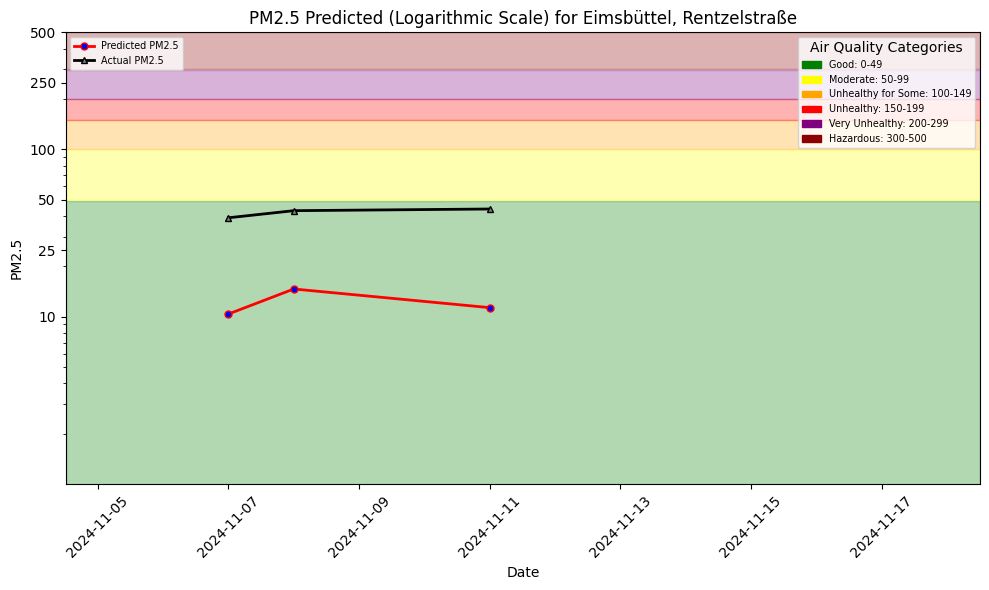

In [56]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---